## WOA7015 Advanced Machine Learning
### Individual Assignment 2

In this workbook, the objective is to implement logistic regression on toy dataset using two approaches: 
1. code logistic regression from scratch 
2. use built-in functions from PyTorch libraries

The discussion on the results are further discussed in a separate report. 

### Key Concepts and Theory
In linear regression, we define the hypothesis function as 
$$
  f_\theta(x) = \theta_0 + \theta_1 x_1 + \dots + \theta_n x_n = \sum \limits _{i=0} ^{n} \theta_i x_i.
$$

Logistic regression applies the sigmoid function to this linear function, which converts it to probabilities in the range $(0,1)$. The hypothesis function for logistic regression is given by 
$$
  h_\theta(x) = \frac{1}{1+\exp(-\theta^T x)} = \frac{\exp(\theta^T x)}{1+\exp(\theta^T x)}.
$$

The **likelihood** for a single instance can then be expressed as:
$$
  P(y_i|x_i; \theta) = h_\theta(x_i)^{y_i} \cdot (1 - h_\theta(x_i))^{1 - y_i}.
$$

The **likelihood for the entire dataset** (assuming $n$ independent instances) is:
$$
L(\theta) = \prod_{i=1}^{n} P(y_i|x_i; \theta) = \prod_{i=1}^{n} \left( h_\theta(x_i)^{y_i} \cdot (1 - h_\theta(x_i))^{1 - y_i} \right).
$$

Taking the **log-likelihood** (to convert the product to a sum) gives:
$$
\ell(\theta) = \log L(\theta) = \sum_{i=1}^{n} \left( y_i \log(h_\theta(x_i)) + (1 - y_i) \log(1 - h_\theta(x_i)) \right).
$$

The **cost function**, or **binary cross-entropy**, is simply the negative of the log-likelihood:
$$
  J(\theta) = -\frac{1}{n} \ell(\theta) = -\frac{1}{n}\sum_{i=1}^{n} \left( y_i \log(h_\theta(x_i)) + (1 - y_i) \log(1 - h_\theta(x_i)) \right).
$$
To make the cost function independent of the dataset size, we have added an averaging term, $\frac{1}{n}$, to cost function above which scales the cost regardless of the input size. This modified cost function will be used to define `CalcObj` in the code below.

The **gradient descent algorithm** aims to minimize the cost function, written mathematically as $\min\limits_{\theta} J(\theta)$ by updating the parameter $\theta_j$ for $j=0, 1, \dots, n$ as follows:
$$
  \theta_j \leftarrow \theta_j - \alpha \frac{\partial}{\partial \theta_j} J(\theta) = \theta_j - \alpha \frac{1}{n} \sum\limits_{i=1}^{n} (h_\theta(x_{i}) - y_{i}) x_{i}.
$$
For `CalcGrad`, we leverage the aggregated sum in the above function, while `UpdateParams` multiplies the aggregated sum with the learning rate $\alpha$ and adding the product to the current parameter, $\theta_j$.

The `GradientDescent` function combines all the steps into a single algorithm that iterates through the process of updating the parameters until convergence, or until reaching a set maximum number of iterations.

Finally, the `PredictLabels` function applies the model trained with this manually constructed logistic regression to the test dataset, producing the predicted $y$ labels and the count of incorrect predictions.


### Part 1: Building Logistic Regression from Scratch

In [1]:
# Import libraries
import numpy as np

In [2]:
# Load the train data
train_data = np.loadtxt('Train_toydata.txt')
X_train = train_data[:, :-1]
y_train = train_data[:, -1]

# Load the test data
test_data = np.loadtxt('Test_toydata.txt')
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

In [3]:
# Define functions which are the building blocks for the gradient descent function below
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def CalcObj(XTrain, YTrain, wHat):
    n = XTrain.shape[0]
    z = np.dot(XTrain, wHat)
    obj = -(1/n) * np.sum(YTrain * np.log(sigmoid(z)) + (1 - YTrain) * (np.log(1 - sigmoid(z))))
    return obj

def CalcGrad(XTrain, YTrain, wHat):
    n = XTrain.shape[0]
    z = np.dot(XTrain, wHat)
    grad = (1/n) * np.dot(XTrain.T, (sigmoid(z) - YTrain))
    return grad
                          
def UpdateParams(weight, grad, lr):
    return weight - lr * grad

def CheckConvg(oldObj, newObj, tol):
    return np.abs(newObj - oldObj) < tol


# Build function to perform the gradient descent algorithm 
def GradientDescent(XTrain, YTrain, lr=0.01, tol=0.001, max_iter=1000):
    XTrain = np.insert(XTrain, 0, 1, axis=1)
    p = XTrain.shape[1]
    wHat = np.zeros(p) # initialize weight to 0
    objVals = [] 

    # Initial objective value
    oldObj = CalcObj(XTrain, YTrain, wHat) # initial objective value with weights=0
    objVals.append(oldObj) 

    for i in range(max_iter):
        grad = CalcGrad(XTrain, YTrain, wHat) # compute gradient 
        wHat = UpdateParams(wHat, grad, lr) # update weights
        newObj = CalcObj(XTrain, YTrain, wHat) # compute new objective value
        objVals.append(newObj) # store the new objective value

        # check for convergence 
        if CheckConvg(oldObj, newObj, tol):
            break

        # update oldObj to the new objective for next iteration if convergence condition not satisfied
        oldObj = newObj

    return wHat, objVals


# Define function to use the tuned weights, wHat on test set for prediction and subsequently compare the accuracy of the prediction
def PredictLabels(Xtest, Ytest, wHat):
    Xtest = np.insert(Xtest, 0, 1, axis=1)
    z = np.dot(Xtest, wHat)
    yHat = (sigmoid(z) >= 0.5).astype(int)
    numErrors = np.sum(yHat != Ytest)
    return yHat, numErrors

In [4]:
# Train the logistic regression model using gradient descent
wHat, objVals = GradientDescent(X_train, y_train)

# Test the logistic regression model
y_hat, numErrors = PredictLabels(X_test, y_test, wHat)

# Compute accuracy
acc = np.sum(y_hat == y_test) / len(y_test)

print(f'Number of Errors: {numErrors}')
print(f'Accuracy: {acc}')

Number of Errors: 1
Accuracy: 0.95


### Part 2: Performing Logistic Regression using Built-in Function

In [5]:
import torch
import torch.nn as nn # provides classes for building neural networks
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)  # PyTorch
np.random.seed(seed) 

In [6]:
# Split train data to train and validation for early stopping
X_train_pytorch, X_val_pytorch, y_train_pytorch, y_val_pytorch = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
XTrain_tensor = torch.tensor(X_train_pytorch, dtype=torch.float32)
YTrain_tensor = torch.tensor(y_train_pytorch, dtype=torch.float32).view(-1, 1)

XVal_tensor = torch.tensor(X_val_pytorch, dtype=torch.float32)
YVal_tensor = torch.tensor(y_val_pytorch, dtype=torch.float32).view(-1, 1)

XTest_tensor = torch.tensor(X_test, dtype=torch.float32)
YTest_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1) 

In [7]:
# Define logistic regression model class using PyTorch
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        out = torch.sigmoid(self.linear(x)) # takes in the linear output and convert to probability
        return out

In [8]:
# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)

criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01) # Stochastic gradient descent

In [9]:
# Parameters for early stopping
patience = 10  # Number of epochs with no improvement after which training will be stopped
min_delta = 0.001  # Minimum change to qualify as an improvement
best_loss = float('inf')  # Initialize best_loss with infinity
epochs_without_improvement = 0  # Counter for epochs without improvement

# Train the model
num_epochs = 1000
all_losses = []

for epoch in range(num_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    outputs = model(XTrain_tensor)
    loss = criterion(outputs, YTrain_tensor)
    all_losses.append(loss.item())
    
    # Backward pass: Compute the gradients and update the weights
    optimizer.zero_grad() # zerorize the gradients
    loss.backward() # compute the gradients via backpropagation
    optimizer.step() # update the weights

    # Check validation loss for early stopping
    with torch.no_grad():  # Disable gradient calculation for validation pass
        val_outputs = model(XVal_tensor)
        val_loss = criterion(val_outputs, YVal_tensor).item()

    # Early stopping condition
    if val_loss < best_loss - min_delta:
        best_loss = val_loss  # Update best_loss
        epochs_without_improvement = 0  # Reset counter if improvement
    else:
        epochs_without_improvement += 1  # Increment counter if no improvement
    
    # Stop training if early stopping condition is met
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}, best validation loss: {best_loss:.4f}")
        break
    
    # Print the training loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

# Output the final training and validation results
print("Training completed.")

Epoch [100/1000], Training Loss: 0.1209, Validation Loss: 0.1505
Epoch [200/1000], Training Loss: 0.1032, Validation Loss: 0.1316
Early stopping at epoch 298, best validation loss: 0.1212
Training completed.


In [10]:
# Test the model
with torch.no_grad(): # disables gradient computation during testing
    # Predict the class labels on the test set
    y_predicted = model(XTest_tensor)
    y_predicted_cls = y_predicted.round()

    # Calculate the number of errors
    num_errors = torch.sum(y_predicted_cls != YTest_tensor).item()
    acc_pytorch = torch.sum(y_predicted_cls == YTest_tensor).item() / YTest_tensor.size(0)

    print(f'Number of Error: {num_errors}')
    print(f'Accuracy: {acc_pytorch}')

Number of Error: 1
Accuracy: 0.95


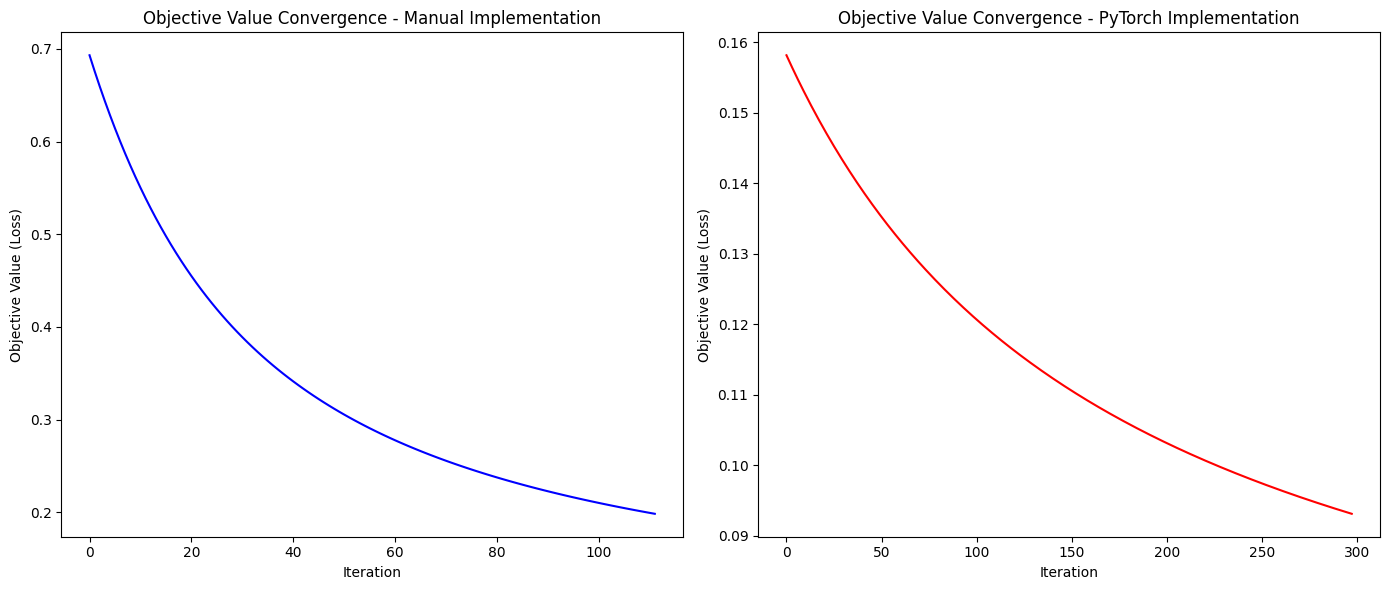

In [11]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot objVals on the first subplot
ax1.plot(objVals, color="blue")
ax1.set_title("Objective Value Convergence - Manual Implementation")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Objective Value (Loss)")

# Plot all_losses on the second subplot
ax2.plot(all_losses, color="red")
ax2.set_title("Objective Value Convergence - PyTorch Implementation")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Objective Value (Loss)")

# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
